In [4]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat, C_origin
from dataset.dataset_config import converted_nodes, converted_edges, river_info # only for visualization
from dataset.traffic_dataset import TrafficDataset
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from utils.visualization import plot_mape_violin, visualize_predictions, add_tod_dow, plot_city_edge_mape
from models.STLinear_biased_models import STLinear_SPE, compute_spe_torch


In [5]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [6]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 64
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [7]:
# 공통 파라미터 및 모델 목록 정의
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
    "STLinear_SPE": STLinear_SPE
}

In [8]:
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드
# ─────────────────────────────────────────────────────────

for name, ModelClass in models.items():
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    kwargs = dict(
            num_nodes=50,            # E
            kernel_size=33,          # 시계열 분해 커널
            in_steps=12,             # 과거 입력 스텝 (기본)
            out_steps=3,             # 예측 스텝 (기본)
            steps_per_day=480,       # 하루 스텝 수 (기본)
            input_dim=3,             # volume/density/flow
            output_dim=3,            # 예측 채널
            # ────────────────────────────────────────
            # STLinear_h1과 동일한 임베딩 크기
            input_embedding_dim=24,  # STLinear 기본
            tod_embedding_dim=24,
            dow_embedding_dim=24,
            spatial_embedding_dim=0, # 원본 STLinear_h1에서는 사용 안 함
            adaptive_embedding_dim=80,
            # ────────────────────────────────────────
            # SPE 관련
            spe_dim=32,              # 고유벡터 개수 (p)
            spe_out_dim=96,          # SPE → 투영 차원
            normalized_laplacian=False,
            # ────────────────────────────────────────
            # 공간 블록 설정 (STLinear_h1과 동일)
            feed_forward_dim=256,    # Self-Attention FFN hidden dim
            num_heads=1,             # max_hop+1 = 1
            num_layers=6,            # 블록 반복 횟수
            dropout=0.14,            # 드롭아웃 비율
            use_mixed_proj=True
    )
    
    model = ModelClass(**kwargs)
    model.to(DEVICE)

    ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    model = model.to(DEVICE)


--- Visualizing STLinear_SPE ---


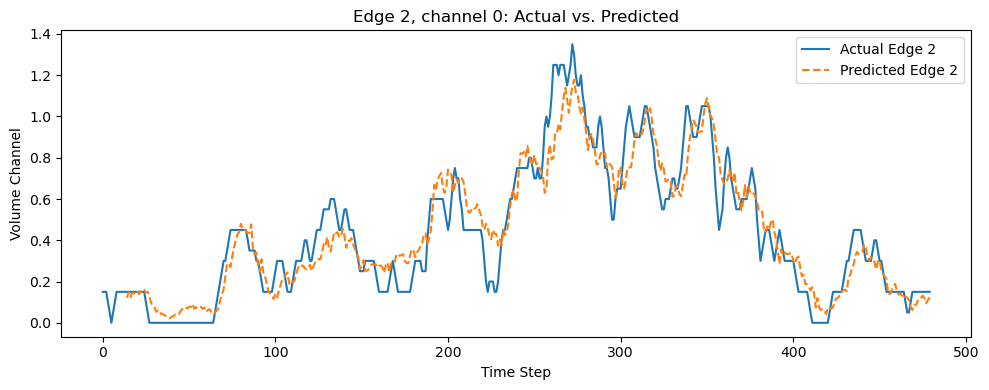

In [9]:
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [2]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [10]:
from dataset.dataset_config import node_idx_map
print(node_idx_map)

{0: (0, 7), 1: (7, 0), 2: (1, 12), 3: (12, 1), 4: (2, 6), 5: (6, 2), 6: (2, 13), 7: (13, 2), 8: (2, 17), 9: (17, 2), 10: (3, 5), 11: (5, 3), 12: (4, 6), 13: (6, 4), 14: (4, 7), 15: (7, 4), 16: (4, 13), 17: (13, 4), 18: (5, 6), 19: (6, 5), 20: (5, 9), 21: (9, 5), 22: (5, 15), 23: (15, 5), 24: (5, 17), 25: (17, 5), 26: (6, 15), 27: (15, 6), 28: (6, 18), 29: (18, 6), 30: (7, 12), 31: (12, 7), 32: (8, 15), 33: (15, 8), 34: (10, 16), 35: (16, 10), 36: (10, 17), 37: (17, 10), 38: (11, 19), 39: (19, 11), 40: (13, 14), 41: (14, 13), 42: (14, 17), 43: (17, 14), 44: (14, 18), 45: (18, 14), 46: (14, 19), 47: (19, 14), 48: (15, 17), 49: (17, 15)}


In [ ]:
# =============================================================================
#  Low-Entropy Head Explorer  (모든 레이어 대상)
# =============================================================================
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
from math import log
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

traffic_data = np.load('dataset/traffic_dataset_13_smoothen.npy')      # (T,E,C)

# ── 유틸 ────────────────────────────────────────────────────────────────
def entropy_by_head(attn):                    # attn: (H,E,E)
    H,E,_ = attn.shape
    return (-(attn.clamp_min(1e-9)*attn.clamp_min(1e-9).log())
            .sum(-1).sum(-1)/log(E))          # (H,)

def plot_topk_heat(attn_map, layer, head, top_k=3):
    E = attn_map.shape[0]
    topk = np.zeros_like(attn_map)
    for i in range(E):
        idx = np.argsort(attn_map[i])[::-1][:top_k]
        topk[i, idx] = attn_map[i, idx]
    plt.figure(figsize=(5,4))
    sns.heatmap(topk, cmap='Blues', cbar_kws={'label':'Top-k Attention'})
    plt.title(f"Layer {layer}, Head {head}, Top-{top_k}")
    plt.xlabel("Key Node"); plt.ylabel("Query Node")
    plt.tight_layout(); plt.show()
    return topk

def plot_timeseries(node_id, t_global, window=48, shade=12, ch=0):
    T = traffic_data.shape[0]
    lo, hi = max(0, t_global-window), min(T, t_global+window+1)
    xs = np.arange(lo, hi)
    plt.figure(figsize=(10,4))
    plt.plot(xs, traffic_data[lo:hi, node_id, ch], lw=1.5)
    plt.axvspan(max(lo, t_global-shade), min(hi, t_global+shade),
                color='k', alpha=.12)
    plt.title(f"Node {node_id} | t={t_global} ±{window}")
    plt.xlabel("Time Index"); plt.ylabel("Traffic Volume")
    plt.tight_layout(); plt.show()

# ── 핵심 함수 ───────────────────────────────────────────────────────────
def explore_low_entropy_heads(model, valid_ds, device,
                              t_global, time_use=0,
                              top_k_head=5,  # 최저 엔트로피 N개만 보여 줌
                              heat_topk=3):  # heat-map 행마다 top-k edge
    # ① 배치 1개 로드
    idx_map = {t0:i for i,t0 in enumerate(valid_ds.starts)}
    subset  = Subset(valid_ds, [idx_map[t_global]])
    loader  = DataLoader(subset, batch_size=1,
                         pin_memory=(device.type=='cuda'))
    data    = next(iter(loader)).to(device)
    x_in    = data.x.unsqueeze(0) if data.x.dim()==3 else data.x   # (1,T,E,C)

    # ② forward + 전체 어텐션 취득
    with torch.no_grad():
        _, attn_list = model(
            x_in,
            getattr(data,'edge_index',None),
            getattr(data,'edge_attr',None),
            return_attn=True
        )                                   # List[layer] (B*T,H,E,E)

    B, T = x_in.size(0), x_in.size(1)
    cand  = []                              # (entropy, layer, head)

    # ③ 엔트로피 스캔
    for l, raw in enumerate(attn_list):
        attn = raw.view(B, T, *raw.shape[1:])[0, time_use]    # (H,E,E)
        ent  = entropy_by_head(attn)                          # (H,)
        for h in range(ent.size(0)):
            cand.append((ent[h].item(), l, h, attn[h]))       # attn 저장

    # ④ 오름차순 정렬 후 top-k
    cand.sort(key=lambda x: x[0])
    top = cand[:top_k_head]

    print(f"\n  t_global={t_global}, time_step={time_use}")
    print("↓ 엔트로피가 가장 낮은 헤드들")
    for i,(e,l,h,_) in enumerate(top,1):
        print(f"  {i}. Layer {l} | Head {h} | Entropy {e:.4f}")

    sel = int(input("\n분석할 번호를 입력하세요 ▶ ")) - 1
    ent, layer_id, head_id, attn_map = top[sel]
    print(f"\n선택 → Layer {layer_id}, Head {head_id}  (Entropy={ent:.4f})")

    # ⑤ Heat-map & 집중 엣지 출력
    topk_mask = plot_topk_heat(attn_map.cpu().numpy(),
                               layer_id, head_id, heat_topk)
    src,dst = np.nonzero(topk_mask)
    edges   = list(zip(src,dst))
    print(f"\n▶ Top-{heat_topk} edge (row,col) 후보 {len(edges)}개:")
    for i,(s,d) in enumerate(edges):
        print(f"  {i}: ({s},{d})")

    edge_idx = int(input("\n시계열을 볼 edge index 선택 ▶ "))
    node_id  = edges[edge_idx][1]          # key 노드 사용
    print(f"\nNode {node_id} 시계열:")
    plot_timeseries(node_id, t_global)



In [14]:
# --------------- 사용 예시 --------------- #
explore_low_entropy_heads(
    model      = model,
    valid_ds   = valid_ds,
    device     = torch.device(DEVICE),
    t_global   = valid_ds.starts[100],
    time_use   = 0,
    top_k_head = 5)


torch.Size([1, 12, 1, 50, 50])


RuntimeError: shape '[1, 12, 12, 1, 50, 50]' is invalid for input of size 30000